## Quality Metrics


The Element also offers Quality Metric visualizations. These are generated using an output from kilosort, `metrics.csv`.

In [1]:
import os

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

In [ ]:
import datajoint as dj
import datetime
import matplotlib.pyplot as plt
import numpy as np
from workflow_array_ephys.pipeline import ephys, probe, ephys_report

First, ensure your `QualityMetrics` table is populated with this data:

In [ ]:
ephys.QualityMetrics.populate()

We'll grab an example key for demonstration.


In [4]:
key = {"subject": "subject5", "insertion_number": 2}

query = ephys.QualityMetrics.Cluster & key
query

subject,session_id,insertion_number,paramset_idx,unit,firing_rate (Hz) firing rate for a unit,snr signal-to-noise ratio for a unit,presence_ratio fraction of time in which spikes are present,isi_violation rate of ISI violation as a fraction of overall rate,number_violation total number of ISI violations,amplitude_cutoff estimate of miss rate based on amplitude histogram,isolation_distance distance to nearest cluster in Mahalanobis space,l_ratio,d_prime Classification accuracy based on LDA,nn_hit_rate Fraction of neighbors for target cluster that are also in target cluster,nn_miss_rate Fraction of neighbors outside target cluster that are in target cluster,silhouette_score Standard metric for cluster overlap,max_drift Maximum change in spike depth throughout recording,cumulative_drift Cumulative change in spike depth throughout recording,contamination_rate
subject5,1,2,0,0,0.327068,5.1741,0.59,nan,None,0.5,36.7421,0.0209872,4.36162,0.294294,0.00054177,0.03586,3.89,5.27,nan
subject5,1,2,0,2,2.16572,4.28818,0.94,nan,None,0.5,57.1309,0.00329259,5.03851,0.979638,0.000313873,0.0973327,8.27,12.48,nan
subject5,1,2,0,3,6.60029,4.63847,0.99,nan,None,0.5,90.4176,0.000410589,6.4374,0.998,0.000469704,0.0733426,3.23,9.03,nan
subject5,1,2,0,4,0.533327,4.56249,0.74,nan,None,0.5,36.7083,0.0265655,2.5544,0.259259,0.00423141,-0.00208076,8.66,17.43,nan
subject5,1,2,0,5,2.29831,5.10661,0.84,nan,None,0.014956,57.8081,0.0143053,4.5877,0.970667,0.00291661,0.0903331,13.15,13.75,nan
subject5,1,2,0,6,9.04003,3.75238,0.99,nan,None,0.5,61.0942,0.0933396,3.19236,0.818,0.0337224,0.0545304,4.72,6.43,nan
subject5,1,2,0,7,0.0707173,3.80121,0.19,nan,None,0.5,690342000000000.0,nan,3.23436,0.1,0.000668003,-0.0111092,nan,0.0,nan
subject5,1,2,0,9,0.0766105,3.87867,0.2,nan,None,0.440071,1083500000000000.0,nan,4.97368,0.173333,0.000401003,nan,nan,0.0,nan
subject5,1,2,0,10,11.194,5.10249,0.99,nan,None,0.5,98.8003,0.0206255,3.76673,0.944667,0.0301297,0.0505288,4.49,7.73,nan
subject5,1,2,0,11,9.22861,4.54963,0.99,nan,None,0.399919,70.3693,0.0228612,4.03329,0.897333,0.0150244,0.0505288,5.41,12.02,nan


In [6]:
# Plotting function

def plot_metric(ax, data, bins, x_axis_label=None, title=None, color='k', max_value=-1):
    """A function modified from https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html
    """
    from scipy.ndimage import gaussian_filter1d
    # Plot data
    h, b = np.histogram(data, bins=bins, density=True)
    x = b[:-1]
    y = gaussian_filter1d(h, 1)

    ax.plot(x, y, color=color)
    ax.set_xlabel(x_axis_label)
    ax.set_title(title)
    ax.get_yaxis().set_visible(False)
    [ax.spines[loc].set_visible(False) for loc in ['right', 'top', 'left']]
    ax.set_ylim([0, None])

### Histograms of following representative metrics will be plotted. 

- `Firing rates (Hz)` : Total number of spikes / time in seconds 

- `Presence ratio` : The proportion of time during a session that a unit is spiking, ranging from 0 to 0.99.

- `Amplitude cut-off`: The false negative rate of a unit measured by the degree to which its distribution of spike amplitudes is truncated, indicating the fraction of missing spikes. An amplitude cutoff of 0.1 indicates approximately 10% missing spikes.

- `L-ratio` : A metric to quantify the distribution of spike distances from a cluster. A low L-ratio indicates that there is a relatively low number of non-member spikes around the target cluster. 

- `Signal-to-noise ratio`: The ratio of the maximum amplitude of the mean spike waveform to the standard deviation of the background noise on a given channel.

- `Isolation distance`: A metric that uses the principal components (PCs) of a unit's waveforms, which are projected into a lower-dimensional PC space after spike sorting. This quantifies how well-isolated the unit is from other potential clusters.

- `D-prime`: A metric calculated from waveform principal components using linear discriminant analysis. This measures the separability of one unit's PC cluster from all the others, with a higher d-prime value indicating better isolation of the unit.

- `Nearest-neighbors hit rate`: This measures the fraction of nearest neighbors for one unit's waveform principal components that fall within the same cluster.

#### For more detailed explanation, please visit the following references:
- https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html

- https://elifesciences.org/articles/61834

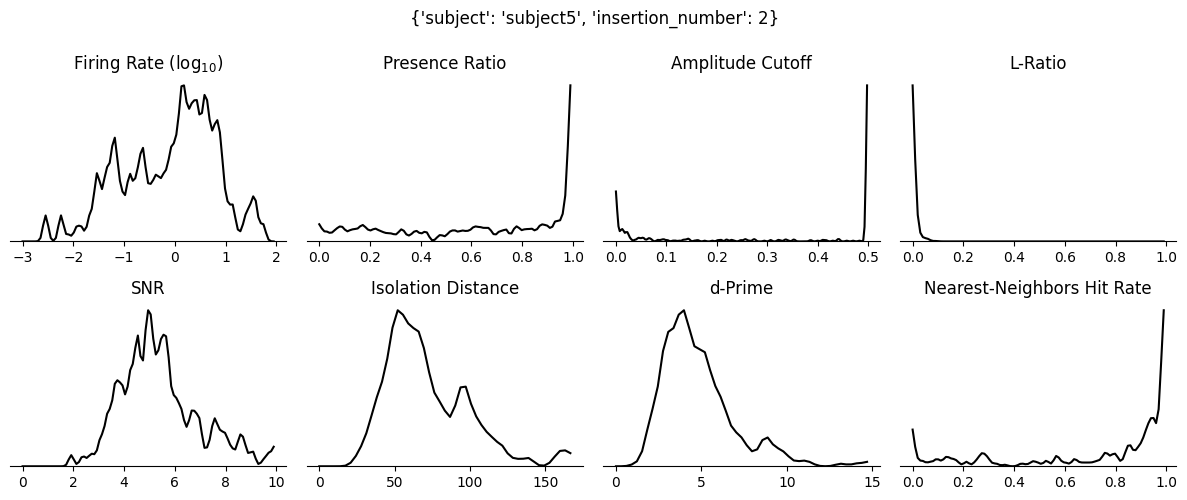

In [13]:
# Plot the results
fig, axes = plt.subplots(2, 4, figsize=(12, 5))
axes = axes.flatten()
plt.suptitle(key, y=.99, fontsize=12)

# # Firing Rates
data = np.log10(query.fetch("firing_rate"))
bins = np.linspace(-3,2,100)
plot_metric(axes[0], data, bins, title="Firing Rate (log$_{10}$)")

# Presence Ratio
data = query.fetch("presence_ratio")
bins = np.linspace(0, 1, 100)
plot_metric(axes[1], data, bins, title="Presence Ratio")

# Amplitude Cutoff
data = query.fetch("amplitude_cutoff")
bins = np.linspace(0, 0.5, 200)
plot_metric(axes[2], data, bins, title="Amplitude Cutoff")

# ISI violation
data = query.fetch("l_ratio")
bins = np.linspace(0, 1, 100)
plot_metric(axes[3], data, bins, title="L-Ratio")

# Signal-to-noise ratio
data = query.fetch("snr")
bins = np.linspace(0, 10, 100)
plot_metric(axes[4], data, bins, title="SNR")

# Isolation Distance
data = query.fetch("isolation_distance")
bins = np.linspace(0, 170, 50)
plot_metric(axes[5], data, bins, title="Isolation Distance")

# d-Prime
data = query.fetch("d_prime")
bins = np.linspace(0, 15, 50)
plot_metric(axes[6], data, bins, title="d-Prime")

# d Prime
data = query.fetch("nn_hit_rate")
bins = np.linspace(0, 1, 100)
plot_metric(axes[7], data, bins, title="Nearest-Neighbors Hit Rate")

plt.tight_layout()